In [210]:
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
# import pymysql  # 导入数据库模块

from datetime import datetime # 时间模块
import statsmodels.formula.api as smf  # OLS regression

# import pyreadr # read RDS file

from matplotlib import style
import matplotlib.pyplot as plt  # 画图模块
import matplotlib.dates as mdates

from matplotlib.font_manager import FontProperties # 作图中文
from pylab import mpl
#mpl.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['font.family'] = 'Times New Roman'

#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

#设置列不限制数量
pd.set_option('display.max_columns', None)

In [211]:
gold = pd.read_csv('./CGM_Shgtrd.csv')
#先把下载的上海黄金及贵重金属日交易文件我们需要的数据提出，
# 黄金价格选择上海黄金交易所黄金现货每日结算价:Au(T+D)，
# 铂金价格选择上海黄金交易所铂金现货每日收盘价(Pt9995)。
gold = gold[(gold['Goldtype'] == 'AU(T+D)') | (gold['Goldtype'] == 'PT9995')]   
gold = gold.rename(columns={'Trddt': 'Day'}) #修改列名
gold = gold.pivot_table(index='Day', columns='Goldtype', values='Clsprcd') #重建行索引
#输出了一次发现早年金数据缺失，从AU(T+D)有值开始
gold.index = pd.to_datetime(gold.index)
gold = gold.sort_index()
start_date = gold['AU(T+D)'].first_valid_index() #first_valid_index()实现找到第一个不为缺失值的
end_date = pd.to_datetime('2025-08-29')
gold = gold.loc[start_date:end_date]


#根据 ln(AU(T+D)/PT9995) 的一阶差分计算 GP黄金、铂金价格比率的变动率序列
gold['GP'] = np.log(gold['AU(T+D)'] / gold['PT9995']).diff()  #用于计算时间序列数据中当前元素与前一个元素的差值。
# 查看结果
gold


Goldtype,AU(T+D),PT9995,GP
Day,,,
2004-09-01,108.49,238.15,NaN
2004-09-02,108.35,240.11,-0.009488
2004-09-03,NaN,237.92,NaN
2004-09-06,NaN,233.25,NaN
2004-09-07,107.35,234.50,NaN
...,...,...,...
2025-08-25,775.34,322.67,-0.001328
2025-08-26,776.83,318.40,0.015242
2025-08-27,777.62,321.36,-0.008237


In [212]:
data = pd.read_csv('./000001.csv')
data['Day'] = pd.to_datetime(data['Day'],format='%Y/%m/%d') #更改Day列格式为XXXX-XX-XX
data.set_index('Day', inplace = True) #重建行索引为Day列
data.sort_values(by = ['Day'], ascending=True) #Day列升序排序


,Preclose,Open,Highest,Lowest,Close
Day,,,,,
1990-12-19,,96.050,99.980,95.790,99.980
1990-12-20,99.98,104.300,104.390,99.980,104.390
1990-12-21,104.39,109.070,109.130,103.730,109.130
1990-12-24,109.13,113.570,114.550,109.130,114.550
1990-12-25,114.55,120.090,120.250,114.550,120.250
...,...,...,...,...,...
2025-08-25,3825.759,3848.163,3883.562,3839.972,3883.562
2025-08-26,3883.562,3871.471,3888.599,3859.758,3868.382
2025-08-27,3868.382,3869.612,3887.198,3800.350,3800.350


In [213]:
# 计算黄金和铂金的日收益率
# 黄金收益率
gold['gold_ret'] = gold['AU(T+D)'].pct_change()
# 铂金收益率
gold['platinum_ret'] = gold['PT9995'].pct_change()

# 创建滞后1、2、3期的收益率列（用于计算RV2和RV3）
gold['gold_ret1'] = gold['gold_ret'].shift(1)  # 滞后1期
gold['gold_ret2'] = gold['gold_ret'].shift(2)  # 滞后2期
gold['gold_ret3'] = gold['gold_ret'].shift(3)  # 滞后3期

gold['platinum_ret1'] = gold['platinum_ret'].shift(1)  # 滞后1期
gold['platinum_ret2'] = gold['platinum_ret'].shift(2)  # 滞后2期
gold['platinum_ret3'] = gold['platinum_ret'].shift(3)  # 滞后3期

# 查看数据
gold[['AU(T+D)', 'PT9995', 'gold_ret', 'platinum_ret', 
      'gold_ret1', 'gold_ret2', 'gold_ret3',
      'platinum_ret1', 'platinum_ret2', 'platinum_ret3']].head(10)


C:\Users\user\AppData\Local\Temp\ipykernel_31836\3743815585.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  gold['gold_ret'] = gold['AU(T+D)'].pct_change()
C:\Users\user\AppData\Local\Temp\ipykernel_31836\3743815585.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  gold['platinum_ret'] = gold['PT9995'].pct_change()


Goldtype,AU(T+D),PT9995,gold_ret,platinum_ret,gold_ret1,gold_ret2,gold_ret3,platinum_ret1,platinum_ret2,platinum_ret3
Day,,,,,,,,,,
2004-09-01,108.49,238.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-02,108.35,240.11,-0.001290,0.008230,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-03,NaN,237.92,0.000000,-0.009121,-0.001290,NaN,NaN,0.008230,NaN,NaN
2004-09-06,NaN,233.25,0.000000,-0.019628,0.000000,-0.001290,NaN,-0.009121,0.008230,NaN
2004-09-07,107.35,234.50,-0.009229,0.005359,0.000000,0.000000,-0.001290,-0.019628,-0.009121,0.008230
2004-09-08,106.35,230.63,-0.009315,-0.016503,-0.009229,0.000000,0.000000,0.005359,-0.019628,-0.009121
2004-09-09,107.56,230.76,0.011378,0.000564,-0.009315,-0.009229,0.000000,-0.016503,0.005359,-0.019628
2004-09-10,107.10,230.31,-0.004277,-0.001950,0.011378,-0.009315,-0.009229,0.000564,-0.016503,0.005359
2004-09-13,107.38,229.69,0.002614,-0.002692,-0.004277,0.011378,-0.009315,-0.001950,0.000564,-0.016503


In [214]:
# 计算黄金的月度已实现方差 RV、RV2、RV3
# 参考 class7.ipynb 中 RV3 的处理方式
gold_variance = gold.resample('ME').apply(lambda df: pd.Series({
    'gold_RV': (df['gold_ret']**2).sum(),
    'gold_RV1': (df['gold_ret']**2).sum() + 2*(df['gold_ret']*df['gold_ret1']).sum(),
    'gold_RV2': (df['gold_ret']**2).sum() + 2*(df['gold_ret']*df['gold_ret1']).sum() + 2*(df['gold_ret']*df['gold_ret2']).sum(),
    'gold_RV3': (df['gold_ret']**2).sum() + 2*(df['gold_ret']*df['gold_ret1']).sum() + 2*(df['gold_ret']*df['gold_ret2']).sum() + 2*(df['gold_ret']*df['gold_ret3']).sum()
}))

# 计算黄金的月度方差（传统方法）
gold_variance['gold_var'] = gold.resample('ME')['gold_ret'].var()
gold_variance.index.name = 'month'

# 处理负值：如果 RV3 < 0，则设为 RV2；如果 RV2 < 0，则设为 RV1；如果 RV1 < 0，则设为 RV
gold_variance['gold_RV1'] = gold_variance['gold_RV1'].where(gold_variance['gold_RV1']>=0, gold_variance['gold_RV'])
gold_variance['gold_RV2'] = gold_variance['gold_RV2'].where(gold_variance['gold_RV2']>=0, gold_variance['gold_RV1'])
gold_variance['gold_RV3'] = gold_variance['gold_RV3'].where(gold_variance['gold_RV3']>=0, gold_variance['gold_RV2'])

print("黄金的月度已实现方差（RV、RV2、RV3）:")
gold_variance


黄金的月度已实现方差（RV、RV2、RV3）:


,gold_RV,gold_RV1,gold_RV2,gold_RV3,gold_var
month,,,,,
2004-09-30,0.000356,0.000212,0.000162,0.000238,0.000018
2004-10-31,0.000538,0.000749,0.000678,0.000726,0.000030
2004-11-30,0.000902,0.000647,0.000788,0.001035,0.000037
2004-12-31,0.001159,0.001132,0.001264,0.001001,0.000052
2005-01-31,0.000782,0.000574,0.000849,0.001212,0.000038
...,...,...,...,...,...
2025-04-30,0.007154,0.005649,0.006364,0.008984,0.000346
2025-05-31,0.004150,0.003529,0.003698,0.005869,0.000230
2025-06-30,0.000945,0.001232,0.000807,0.000944,0.000050


In [215]:
# 计算铂金的月度已实现方差 RV、RV2、RV3
platinum_variance = gold.resample('ME').apply(lambda df: pd.Series({
    'platinum_RV': (df['platinum_ret']**2).sum(),
    'platinum_RV1': (df['platinum_ret']**2).sum() + 2*(df['platinum_ret']*df['platinum_ret1']).sum(),
    'platinum_RV2': (df['platinum_ret']**2).sum() + 2*(df['platinum_ret']*df['platinum_ret1']).sum() + 2*(df['platinum_ret']*df['platinum_ret2']).sum(),
    'platinum_RV3': (df['platinum_ret']**2).sum() + 2*(df['platinum_ret']*df['platinum_ret1']).sum() + 2*(df['platinum_ret']*df['platinum_ret2']).sum() + 2*(df['platinum_ret']*df['platinum_ret3']).sum()
}))

# 计算铂金的月度方差（传统方法）
platinum_variance['platinum_var'] = gold.resample('ME')['platinum_ret'].var()
platinum_variance.index.name = 'month'

# 处理负值：如果 RV3 < 0，则设为 RV2；如果 RV2 < 0，则设为 RV1；如果 RV1 < 0，则设为 RV
platinum_variance['platinum_RV1'] = platinum_variance['platinum_RV1'].where(platinum_variance['platinum_RV1']>=0, platinum_variance['platinum_RV'])
platinum_variance['platinum_RV2'] = platinum_variance['platinum_RV2'].where(platinum_variance['platinum_RV2']>=0, platinum_variance['platinum_RV1'])
platinum_variance['platinum_RV3'] = platinum_variance['platinum_RV3'].where(platinum_variance['platinum_RV3']>=0, platinum_variance['platinum_RV2'])

print("铂金的月度已实现方差（RV、RV2、RV3）:")
platinum_variance


铂金的月度已实现方差（RV、RV2、RV3）:


,platinum_RV,platinum_RV1,platinum_RV2,platinum_RV3,platinum_var
month,,,,,
2004-09-30,0.001216,0.000862,0.001021,0.001538,0.000060
2004-10-31,0.001475,0.000408,0.001069,0.000614,0.000096
2004-11-30,0.002524,0.002367,0.000864,0.000690,0.000117
2004-12-31,0.001926,0.002550,0.002098,0.001730,0.000087
2005-01-31,0.000585,0.000573,0.000655,0.000630,0.000030
...,...,...,...,...,...
2025-04-30,0.003323,0.002714,0.002504,0.000936,0.000166
2025-05-31,0.003448,0.006087,0.007642,0.007782,0.000174
2025-06-30,0.017157,0.024446,0.026479,0.034060,0.000745


In [216]:
# 合并黄金和铂金的方差数据
variance_data = pd.merge(gold_variance, platinum_variance, on='month', how='outer')
variance_data = variance_data.sort_index()

print("黄金和铂金的月度已实现方差汇总:")
print(f"数据时间范围: {variance_data.index.min()} 至 {variance_data.index.max()}")
print(f"总月数: {len(variance_data)}")
print("\n前10行数据:")
variance_data.head(10)


黄金和铂金的月度已实现方差汇总:
数据时间范围: 2004-09-30 00:00:00 至 2025-08-31 00:00:00
总月数: 252

前10行数据:


,gold_RV,gold_RV1,gold_RV2,gold_RV3,gold_var,platinum_RV,platinum_RV1,platinum_RV2,platinum_RV3,platinum_var
month,,,,,,,,,,
2004-09-30,0.000356,0.000212,0.000162,0.000238,0.000018,0.001216,0.000862,0.001021,0.001538,0.000060
2004-10-31,0.000538,0.000749,0.000678,0.000726,0.000030,0.001475,0.000408,0.001069,0.000614,0.000096
2004-11-30,0.000902,0.000647,0.000788,0.001035,0.000037,0.002524,0.002367,0.000864,0.000690,0.000117
2004-12-31,0.001159,0.001132,0.001264,0.001001,0.000052,0.001926,0.002550,0.002098,0.001730,0.000087
2005-01-31,0.000782,0.000574,0.000849,0.001212,0.000038,0.000585,0.000573,0.000655,0.000630,0.000030
2005-02-28,0.000448,0.000406,0.000594,0.000731,0.000032,0.000758,0.000298,0.000671,0.000357,0.000063
2005-03-31,0.000369,0.000432,0.000574,0.000828,0.000016,0.000768,0.000502,0.000564,0.000233,0.000035
2005-04-30,0.000368,0.000321,0.000091,0.000203,0.000018,0.000436,0.000551,0.000279,0.000140,0.000022
2005-05-31,0.000314,0.000429,0.000373,0.000374,0.000015,0.000400,0.000422,0.000195,0.000195,0.000025


In [217]:
# 描述性统计
print("="*80)
print("黄金已实现方差的描述性统计:")
print("="*80)
print(variance_data[['gold_RV', 'gold_RV2', 'gold_RV3', 'gold_var']].describe())

print("\n" + "="*80)
print("铂金已实现方差的描述性统计:")
print("="*80)
print(variance_data[['platinum_RV', 'platinum_RV2', 'platinum_RV3', 'platinum_var']].describe())

# 准备股票月度收益率数据（用于预测）
# 从 data 中计算月度对数收益率
if 'Log_return' not in data.columns:
    if 'Close' in data.columns and 'Preclose' in data.columns:
        # 先将字符串转换为数值类型（处理可能的字符串数据）
        data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
        data['Preclose'] = pd.to_numeric(data['Preclose'], errors='coerce')
        data['Log_return'] = np.log(data['Close']) - np.log(data['Preclose'])
    elif 'Close' in data.columns:
        # 先将字符串转换为数值类型
        data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
        data['Log_return'] = np.log(data['Close']) - np.log(data['Close'].shift(1))
    else:
        print("警告：无法计算 Log_return，请检查 data 数据结构")

# 计算月度收益率（将日度对数收益率聚合为月度）
monthly_ret = data['Log_return'].resample('ME').sum()
monthly_ret.name = 'ret'
monthly_ret.index.name = 'month'

# 合并股票收益率和黄金方差数据
reg_data = pd.merge(monthly_ret.to_frame(), variance_data, on='month', how='inner')
reg_data = reg_data.sort_index()

print("\n" + "="*80)
print("合并后的回归数据:")
print("="*80)
print(f"数据时间范围: {reg_data.index.min()} 至 {reg_data.index.max()}")
print(f"总月数: {len(reg_data)}")
reg_data.head(10)


黄金已实现方差的描述性统计:
          gold_RV    gold_RV2    gold_RV3    gold_var
count  252.000000  252.000000  252.000000  252.000000
mean     0.002024    0.002112    0.002223    0.000101
std      0.002469    0.003007    0.003266    0.000125
min      0.000131    0.000004    0.000009    0.000006
25%      0.000670    0.000542    0.000459    0.000033
50%      0.001263    0.001264    0.001103    0.000060
75%      0.002301    0.002258    0.002473    0.000114
max      0.019988    0.021152    0.022882    0.000983

铂金已实现方差的描述性统计:
       platinum_RV  platinum_RV2  platinum_RV3  platinum_var
count   252.000000    252.000000    252.000000    252.000000
mean      0.004052      0.004535      0.004596      0.000202
std       0.004984      0.007066      0.007715      0.000239
min       0.000400      0.000085      0.000140      0.000018
25%       0.001594      0.001312      0.001280      0.000080
50%       0.002732      0.002610      0.002550      0.000132
75%       0.004558      0.005021      0.004787      0.00

,ret,gold_RV,gold_RV1,gold_RV2,gold_RV3,gold_var,platinum_RV,platinum_RV1,platinum_RV2,platinum_RV3,platinum_var
month,,,,,,,,,,,
2004-09-30,0.039907,0.000356,0.000212,0.000162,0.000238,0.000018,0.001216,0.000862,0.001021,0.001538,0.000060
2004-10-31,-0.056072,0.000538,0.000749,0.000678,0.000726,0.000030,0.001475,0.000408,0.001069,0.000614,0.000096
2004-11-30,0.015203,0.000902,0.000647,0.000788,0.001035,0.000037,0.002524,0.002367,0.000864,0.000690,0.000117
2004-12-31,-0.056987,0.001159,0.001132,0.001264,0.001001,0.000052,0.001926,0.002550,0.002098,0.001730,0.000087
2005-01-31,-0.060776,0.000782,0.000574,0.000849,0.001212,0.000038,0.000585,0.000573,0.000655,0.000630,0.000030
2005-02-28,0.091487,0.000448,0.000406,0.000594,0.000731,0.000032,0.000758,0.000298,0.000671,0.000357,0.000063
2005-03-31,-0.100404,0.000369,0.000432,0.000574,0.000828,0.000016,0.000768,0.000502,0.000564,0.000233,0.000035
2005-04-30,-0.018878,0.000368,0.000321,0.000091,0.000203,0.000018,0.000436,0.000551,0.000279,0.000140,0.000022
2005-05-31,-0.088720,0.000314,0.000429,0.000373,0.000374,0.000015,0.000400,0.000422,0.000195,0.000195,0.000025


In [218]:
# 创建滞后1期的黄金 RV、RV1、RV2、RV3 变量（参考 class7.ipynb Cell 27）
reg_data['lgold_RV'] = reg_data['gold_RV'].shift(1)
reg_data['lgold_RV1'] = reg_data['gold_RV1'].shift(1)
reg_data['lgold_RV2'] = reg_data['gold_RV2'].shift(1)
reg_data['lgold_RV3'] = reg_data['gold_RV3'].shift(1)

# 使用滞后1期的黄金 RV、RV1、RV2、RV3 预测股票收益率
# 参考 class7.ipynb 的做法
model_gold_rv = smf.ols('ret ~ lgold_RV',
                 data=reg_data['2004-10':'2025-08']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
model_gold_rv1 = smf.ols('ret ~ lgold_RV1',
                 data=reg_data['2004-10':'2025-08']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
model_gold_rv2 = smf.ols('ret ~ lgold_RV2',
                 data=reg_data['2004-10':'2025-08']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
model_gold_rv3 = smf.ols('ret ~ lgold_RV3',
                 data=reg_data['2004-10':'2025-08']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})

# 打印所有模型结果（参考 class7.ipynb Cell 27）
print("=" * 80)
print("Model with lgold_RV:")
print("=" * 80)
print(model_gold_rv.summary())

print("\n" + "=" * 80)
print("Model with lgold_RV1:")
print("=" * 80)
print(model_gold_rv1.summary())

print("\n" + "=" * 80)
print("Model with lgold_RV2:")
print("=" * 80)
print(model_gold_rv2.summary())

print("\n" + "=" * 80)
print("Model with lgold_RV3:")
print("=" * 80)
print(model_gold_rv3.summary())


Model with lgold_RV:
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2058
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.650
Time:                        00:32:38   Log-Likelihood:                 301.97
No. Observations:                 251   AIC:                            -599.9
Df Residuals:                     249   BIC:                            -592.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0025      0.00

In [219]:
# 创建对比表（参考 class7.ipynb Cell 29）
from statsmodels.iolib.summary2 import summary_col

# 创建对比表：黄金的 RV、RV1、RV2、RV3
print("\n" + "="*80)
print("黄金已实现方差预测模型对比（滞后1期）")
print("="*80)
results_table_gold = summary_col(
    [model_gold_rv, model_gold_rv1, model_gold_rv2, model_gold_rv3],
    model_names=['黄金 RV', '黄金 RV1', '黄金 RV2', '黄金 RV3'],
    stars=True,
    float_format='%.4f',
    info_dict={
        'N': lambda x: f"{int(x.nobs)}"
    }
)
print(results_table_gold)



黄金已实现方差预测模型对比（滞后1期）

                黄金 RV    黄金 RV1   黄金 RV2   黄金 RV3 
--------------------------------------------------
Intercept      0.0025   0.0048   0.0058   0.0046  
               (0.0058) (0.0062) (0.0063) (0.0061)
lgold_RV       0.7415                             
               (1.6343)                           
lgold_RV1               -0.3743                   
                        (2.0347)                  
lgold_RV2                        -0.8463          
                                 (2.2028)         
lgold_RV3                                 -0.2515 
                                          (1.9748)
R-squared      0.0006   0.0002   0.0012   0.0001  
R-squared Adj. -0.0034  -0.0038  -0.0028  -0.0039 
N              251      251      251      251     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [220]:
# ========== 季度数据预测（参考月度数据的方法）==========
# 计算黄金的季度已实现方差 RV、RV2、RV3（使用日度数据聚合到季度）
# 参考 class7.ipynb 的做法
gold_variance_Q = gold.resample('QE').apply(lambda df: pd.Series({
    'gold_RV': (df['gold_ret']**2).sum(),
    'gold_RV1': (df['gold_ret']**2).sum() + 2*(df['gold_ret']*df['gold_ret1']).sum(),
    'gold_RV2': (df['gold_ret']**2).sum() + 2*(df['gold_ret']*df['gold_ret1']).sum() + 2*(df['gold_ret']*df['gold_ret2']).sum(),
    'gold_RV3': (df['gold_ret']**2).sum() + 2*(df['gold_ret']*df['gold_ret1']).sum() + 2*(df['gold_ret']*df['gold_ret2']).sum() + 2*(df['gold_ret']*df['gold_ret3']).sum()
}))

# 处理负值
gold_variance_Q['gold_RV1'] = gold_variance_Q['gold_RV1'].where(gold_variance_Q['gold_RV1']>=0, gold_variance_Q['gold_RV'])
gold_variance_Q['gold_RV2'] = gold_variance_Q['gold_RV2'].where(gold_variance_Q['gold_RV2']>=0, gold_variance_Q['gold_RV1'])
gold_variance_Q['gold_RV3'] = gold_variance_Q['gold_RV3'].where(gold_variance_Q['gold_RV3']>=0, gold_variance_Q['gold_RV2'])
gold_variance_Q.index.name = 'Q'

print("黄金的季度已实现方差（RV、RV2、RV3）:")
print(f"数据时间范围: {gold_variance_Q.index.min()} 至 {gold_variance_Q.index.max()}")
print(f"总季度数: {len(gold_variance_Q)}")
gold_variance_Q.head(10)


黄金的季度已实现方差（RV、RV2、RV3）:
数据时间范围: 2004-09-30 00:00:00 至 2025-09-30 00:00:00
总季度数: 85


,gold_RV,gold_RV1,gold_RV2,gold_RV3
Q,,,,
2004-09-30,0.000356,0.000212,0.000162,0.000238
2004-12-31,0.002599,0.002528,0.002730,0.002762
2005-03-31,0.001599,0.001412,0.002017,0.002771
2005-06-30,0.001324,0.001402,0.001264,0.001094
2005-09-30,0.002628,0.002589,0.003017,0.003105
2005-12-31,0.005986,0.008034,0.007491,0.008237
2006-03-31,0.008744,0.007754,0.004240,0.010422
2006-06-30,0.027119,0.017586,0.026519,0.031159
2006-09-30,0.013974,0.014950,0.012817,0.018848


In [221]:
# 计算股票季度收益率（将月度收益率复合成季度，参考 class7.ipynb）
# 使用 np.prod(1 + ret) - 1 来复合成季度收益率
Q_ret = reg_data['2004-10':'2025-08'].resample('QE').apply(
    lambda df: pd.Series({
        'ret': np.prod(1 + df['ret']) - 1
    })
)
Q_ret.index.name = 'Q'

print("股票季度收益率:")
print(f"数据时间范围: {Q_ret.index.min()} 至 {Q_ret.index.max()}")
print(f"总季度数: {len(Q_ret)}")
Q_ret.head(10)


股票季度收益率:
数据时间范围: 2004-12-31 00:00:00 至 2025-09-30 00:00:00
总季度数: 84


,ret
Q,
2004-12-31,-0.096330
2005-03-31,-0.077778
2005-06-30,-0.089057
2005-09-30,0.066481
2005-12-31,0.001625
2006-03-31,0.114230
2006-06-30,0.271275
2006-09-30,0.045331
2006-12-31,0.474802


In [222]:
# 合并股票季度收益率和黄金季度方差数据
Qreg_data = pd.merge(Q_ret, gold_variance_Q, on='Q', how='inner')
Qreg_data = Qreg_data.sort_index()

print("="*80)
print("合并后的季度回归数据:")
print("="*80)
print(f"数据时间范围: {Qreg_data.index.min()} 至 {Qreg_data.index.max()}")
print(f"总季度数: {len(Qreg_data)}")
Qreg_data.head(10)


合并后的季度回归数据:
数据时间范围: 2004-12-31 00:00:00 至 2025-09-30 00:00:00
总季度数: 84


,ret,gold_RV,gold_RV1,gold_RV2,gold_RV3
Q,,,,,
2004-12-31,-0.096330,0.002599,0.002528,0.002730,0.002762
2005-03-31,-0.077778,0.001599,0.001412,0.002017,0.002771
2005-06-30,-0.089057,0.001324,0.001402,0.001264,0.001094
2005-09-30,0.066481,0.002628,0.002589,0.003017,0.003105
2005-12-31,0.001625,0.005986,0.008034,0.007491,0.008237
2006-03-31,0.114230,0.008744,0.007754,0.004240,0.010422
2006-06-30,0.271275,0.027119,0.017586,0.026519,0.031159
2006-09-30,0.045331,0.013974,0.014950,0.012817,0.018848
2006-12-31,0.474802,0.005468,0.005709,0.005446,0.004452


In [223]:
# 创建滞后1期的黄金 RV、RV1、RV2、RV3 变量（季度数据，参考月度数据的方法）
Qreg_data['lgold_RV'] = Qreg_data['gold_RV'].shift(1)
Qreg_data['lgold_RV1'] = Qreg_data['gold_RV1'].shift(1)
Qreg_data['lgold_RV2'] = Qreg_data['gold_RV2'].shift(1)
Qreg_data['lgold_RV3'] = Qreg_data['gold_RV3'].shift(1)

# 使用滞后1期的黄金 RV、RV1、RV2、RV3 预测股票季度收益率
# 参考 class7.ipynb 的做法，季度数据使用 maxlags=2
model_Q_gold_rv = smf.ols('ret ~ lgold_RV',
                 data=Qreg_data['2004-12':'2025-06']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_Q_gold_rv1 = smf.ols('ret ~ lgold_RV1',
                 data=Qreg_data['2004-12':'2025-06']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_Q_gold_rv2 = smf.ols('ret ~ lgold_RV2',
                 data=Qreg_data['2004-12':'2025-06']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_Q_gold_rv3 = smf.ols('ret ~ lgold_RV3',
                 data=Qreg_data['2004-12':'2025-06']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})

# 打印所有模型结果（参考 class7.ipynb Cell 27）
print("=" * 80)
print("季度数据 - Model with lgold_RV:")
print("=" * 80)
print(model_Q_gold_rv.summary())

print("\n" + "=" * 80)
print("季度数据 - Model with lgold_RV1:")
print("=" * 80)
print(model_Q_gold_rv1.summary())

print("\n" + "=" * 80)
print("季度数据 - Model with lgold_RV2:")
print("=" * 80)
print(model_Q_gold_rv2.summary())

print("\n" + "=" * 80)
print("季度数据 - Model with lgold_RV3:")
print("=" * 80)
print(model_Q_gold_rv3.summary())


季度数据 - Model with lgold_RV:
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.105
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.296
Time:                        00:32:39   Log-Likelihood:                 44.026
No. Observations:                  82   AIC:                            -84.05
Df Residuals:                      80   BIC:                            -79.24
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0044   

In [224]:
# 创建季度数据对比表（参考 class7.ipynb Cell 29）
from statsmodels.iolib.summary2 import summary_col

# 创建对比表：黄金的 RV、RV1、RV2、RV3（季度数据）
print("\n" + "="*80)
print("黄金已实现方差预测模型对比（季度数据，滞后1期）")
print("="*80)
results_table_Q_gold = summary_col(
    [model_Q_gold_rv, model_Q_gold_rv1, model_Q_gold_rv2, model_Q_gold_rv3],
    model_names=['黄金 RV', '黄金 RV1', '黄金 RV2', '黄金 RV3'],
    stars=True,
    float_format='%.4f',
    info_dict={
        'N': lambda x: f"{int(x.nobs)}"
    }
)
print(results_table_Q_gold)



黄金已实现方差预测模型对比（季度数据，滞后1期）

                黄金 RV    黄金 RV1   黄金 RV2   黄金 RV3 
--------------------------------------------------
Intercept      -0.0044  -0.0068  0.0045   -0.0038 
               (0.0188) (0.0195) (0.0196) (0.0184)
lgold_RV       3.0245                             
               (2.8772)                           
lgold_RV1               3.4841                    
                        (3.4046)                  
lgold_RV2                        1.5122           
                                 (2.8220)         
lgold_RV3                                 2.7475  
                                          (2.5348)
R-squared      0.0162   0.0209   0.0053   0.0210  
R-squared Adj. 0.0039   0.0086   -0.0071  0.0087  
N              82       82       82       82      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [225]:
# ========== 年度数据预测（参考季度数据的方法）==========
# 计算黄金的年度已实现方差 RV、RV2、RV3（使用日度数据聚合到年度）
# 参考季度数据的做法，使用 'YE' (Year End) 或 'A' (Annual)
gold_variance_Y = gold.resample('YE').apply(lambda df: pd.Series({
    'gold_RV': (df['gold_ret']**2).sum(),
    'gold_RV1': (df['gold_ret']**2).sum() + 2*(df['gold_ret']*df['gold_ret1']).sum(),
    'gold_RV2': (df['gold_ret']**2).sum() + 2*(df['gold_ret']*df['gold_ret1']).sum() + 2*(df['gold_ret']*df['gold_ret2']).sum(),
    'gold_RV3': (df['gold_ret']**2).sum() + 2*(df['gold_ret']*df['gold_ret1']).sum() + 2*(df['gold_ret']*df['gold_ret2']).sum() + 2*(df['gold_ret']*df['gold_ret3']).sum()
}))

# 处理负值
gold_variance_Y['gold_RV1'] = gold_variance_Y['gold_RV1'].where(gold_variance_Y['gold_RV1']>=0, gold_variance_Y['gold_RV'])
gold_variance_Y['gold_RV2'] = gold_variance_Y['gold_RV2'].where(gold_variance_Y['gold_RV2']>=0, gold_variance_Y['gold_RV1'])
gold_variance_Y['gold_RV3'] = gold_variance_Y['gold_RV3'].where(gold_variance_Y['gold_RV3']>=0, gold_variance_Y['gold_RV2'])
gold_variance_Y.index.name = 'Year'

print("黄金的年度已实现方差（RV、RV2、RV3）:")
print(f"数据时间范围: {gold_variance_Y.index.min()} 至 {gold_variance_Y.index.max()}")
print(f"总年数: {len(gold_variance_Y)}")
gold_variance_Y


黄金的年度已实现方差（RV、RV2、RV3）:
数据时间范围: 2004-12-31 00:00:00 至 2025-12-31 00:00:00
总年数: 22


,gold_RV,gold_RV1,gold_RV2,gold_RV3
Year,,,,
2004-12-31,0.002955,0.002739,0.002892,0.003000
2005-12-31,0.011538,0.013437,0.013789,0.015207
2006-12-31,0.055305,0.045999,0.049023,0.064881
2007-12-31,0.018812,0.018714,0.021249,0.020530
2008-12-31,0.079650,0.086368,0.098666,0.097936
2009-12-31,0.039419,0.036321,0.036834,0.035801
2010-12-31,0.021116,0.018999,0.020628,0.018130
2011-12-31,0.041843,0.034081,0.035197,0.037662
2012-12-31,0.019688,0.017557,0.017457,0.013354


In [226]:
# 计算股票年度收益率（将月度收益率复合成年度，参考季度数据的做法）
# 使用 np.prod(1 + ret) - 1 来复合成年度收益率
Y_ret = reg_data['2004-10':'2025-08'].resample('YE').apply(
    lambda df: pd.Series({
        'ret': np.prod(1 + df['ret']) - 1
    })
)
Y_ret.index.name = 'Year'

print("股票年度收益率:")
print(f"数据时间范围: {Y_ret.index.min()} 至 {Y_ret.index.max()}")
print(f"总年数: {len(Y_ret)}")
Y_ret


股票年度收益率:
数据时间范围: 2004-12-31 00:00:00 至 2025-12-31 00:00:00
总年数: 22


,ret
Year,
2004-12-31,-0.096330
2005-12-31,-0.102603
2006-12-31,1.183745
2007-12-31,0.817090
2008-12-31,-0.702141
2009-12-31,0.673011
2010-12-31,-0.167614
2011-12-31,-0.226522
2012-12-31,0.010706


In [227]:
# 合并股票年度收益率和黄金年度方差数据
Yreg_data = pd.merge(Y_ret, gold_variance_Y, on='Year', how='inner')
Yreg_data = Yreg_data.sort_index()

print("="*80)
print("合并后的年度回归数据:")
print("="*80)
print(f"数据时间范围: {Yreg_data.index.min()} 至 {Yreg_data.index.max()}")
print(f"总年数: {len(Yreg_data)}")
Yreg_data


合并后的年度回归数据:
数据时间范围: 2004-12-31 00:00:00 至 2025-12-31 00:00:00
总年数: 22


,ret,gold_RV,gold_RV1,gold_RV2,gold_RV3
Year,,,,,
2004-12-31,-0.096330,0.002955,0.002739,0.002892,0.003000
2005-12-31,-0.102603,0.011538,0.013437,0.013789,0.015207
2006-12-31,1.183745,0.055305,0.045999,0.049023,0.064881
2007-12-31,0.817090,0.018812,0.018714,0.021249,0.020530
2008-12-31,-0.702141,0.079650,0.086368,0.098666,0.097936
2009-12-31,0.673011,0.039419,0.036321,0.036834,0.035801
2010-12-31,-0.167614,0.021116,0.018999,0.020628,0.018130
2011-12-31,-0.226522,0.041843,0.034081,0.035197,0.037662
2012-12-31,0.010706,0.019688,0.017557,0.017457,0.013354


In [228]:
# 创建滞后1期的黄金 RV、RV1、RV2、RV3 变量（年度数据，参考季度数据的方法）
Yreg_data['lgold_RV'] = Yreg_data['gold_RV'].shift(1)
Yreg_data['lgold_RV1'] = Yreg_data['gold_RV1'].shift(1)
Yreg_data['lgold_RV2'] = Yreg_data['gold_RV2'].shift(1)
Yreg_data['lgold_RV3'] = Yreg_data['gold_RV3'].shift(1)

# 使用滞后1期的黄金 RV、RV1、RV2、RV3 预测股票年度收益率
# 参考季度数据的做法，年度数据也使用 maxlags=2（或更小，因为年度数据样本较少）
model_Y_gold_rv = smf.ols('ret ~ lgold_RV',
                 data=Yreg_data).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_Y_gold_rv1 = smf.ols('ret ~ lgold_RV1',
                 data=Yreg_data).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_Y_gold_rv2 = smf.ols('ret ~ lgold_RV2',
                 data=Yreg_data).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_Y_gold_rv3 = smf.ols('ret ~ lgold_RV3',
                 data=Yreg_data).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})

# 打印所有模型结果（参考季度数据的方法）
print("=" * 80)
print("年度数据 - Model with lgold_RV:")
print("=" * 80)
print(model_Y_gold_rv.summary())

print("\n" + "=" * 80)
print("年度数据 - Model with lgold_RV1:")
print("=" * 80)
print(model_Y_gold_rv1.summary())

print("\n" + "=" * 80)
print("年度数据 - Model with lgold_RV2:")
print("=" * 80)
print(model_Y_gold_rv2.summary())

print("\n" + "=" * 80)
print("年度数据 - Model with lgold_RV3:")
print("=" * 80)
print(model_Y_gold_rv3.summary())


年度数据 - Model with lgold_RV:
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     10.36
Date:                Mon, 17 Nov 2025   Prob (F-statistic):            0.00452
Time:                        00:32:39   Log-Likelihood:                -8.9355
No. Observations:                  21   AIC:                             21.87
Df Residuals:                      19   BIC:                             23.96
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1072   

In [229]:
# ========== 半年期数据预测（从2005年开始）==========
# 计算黄金的半年期已实现方差 RV、RV1、RV2、RV3（使用日度数据聚合到半年期）
# 使用 '6ME' (6个月末) 来代表半年期，从2005年开始
gold_variance_H = gold['2005-01-01':].resample('6ME').apply(lambda df: pd.Series({
    'gold_RV': (df['gold_ret']**2).sum(),
    'gold_RV1': (df['gold_ret']**2).sum() + 2*(df['gold_ret']*df['gold_ret1']).sum(),
    'gold_RV2': (df['gold_ret']**2).sum() + 2*(df['gold_ret']*df['gold_ret1']).sum() + 2*(df['gold_ret']*df['gold_ret2']).sum(),
    'gold_RV3': (df['gold_ret']**2).sum() + 2*(df['gold_ret']*df['gold_ret1']).sum() + 2*(df['gold_ret']*df['gold_ret2']).sum() + 2*(df['gold_ret']*df['gold_ret3']).sum()
}))

# 处理负值
gold_variance_H['gold_RV1'] = gold_variance_H['gold_RV1'].where(gold_variance_H['gold_RV1']>=0, gold_variance_H['gold_RV'])
gold_variance_H['gold_RV2'] = gold_variance_H['gold_RV2'].where(gold_variance_H['gold_RV2']>=0, gold_variance_H['gold_RV1'])
gold_variance_H['gold_RV3'] = gold_variance_H['gold_RV3'].where(gold_variance_H['gold_RV3']>=0, gold_variance_H['gold_RV2'])

print("黄金的半年期已实现方差（RV、RV1、RV2、RV3）:")
print(f"数据时间范围: {gold_variance_H.index.min()} 至 {gold_variance_H.index.max()}")
print(f"总半年期数: {len(gold_variance_H)}")
gold_variance_H.head(10)


黄金的半年期已实现方差（RV、RV1、RV2、RV3）:
数据时间范围: 2005-01-31 00:00:00 至 2026-01-31 00:00:00
总半年期数: 43


,gold_RV,gold_RV1,gold_RV2,gold_RV3
Day,,,,
2005-01-31,0.000782,0.000574,0.000849,0.001212
2005-07-31,0.002712,0.002794,0.002908,0.003419
2006-01-31,0.010954,0.012029,0.011320,0.014543
2006-07-31,0.040310,0.032789,0.036984,0.048739
2007-01-31,0.013386,0.012745,0.012216,0.013699
2007-07-31,0.007573,0.008152,0.007961,0.007938
2008-01-31,0.015603,0.013687,0.017953,0.017354
2008-07-31,0.021682,0.028853,0.029441,0.024487
2009-01-31,0.056072,0.053610,0.065878,0.071500


In [230]:
# 计算股票半年期收益率（将月度收益率复合成半年期，从2005年开始）
# 使用 '6ME' (6个月末) 来代表半年期，与黄金方差数据对齐
# 使用 np.prod(1 + ret) - 1 来复合成半年期收益率
H_ret = reg_data['2005-01-01':].resample('6ME').apply(
    lambda df: pd.Series({
        'ret': np.prod(1 + df['ret']) - 1
    })
)

print("股票半年期收益率:")
print(f"数据时间范围: {H_ret.index.min()} 至 {H_ret.index.max()}")
print(f"总半年期数: {len(H_ret)}")
H_ret.head(10)


股票半年期收益率:
数据时间范围: 2005-01-31 00:00:00 至 2026-01-31 00:00:00
总半年期数: 43


,ret
month,
2005-01-31,-0.060776
2005-07-31,-0.103820
2006-01-31,0.151691
2006-07-31,0.263797
2007-01-31,0.664539
2007-07-31,0.546211
2008-01-31,-0.076889
2008-07-31,-0.406669
2009-01-31,-0.331064


In [231]:
# 合并股票半年期收益率和黄金半年期方差数据
# 使用索引直接合并（join），因为两个数据集的索引都是日期时间
Hreg_data = H_ret.join(gold_variance_H, how='inner')
Hreg_data = Hreg_data.sort_index()

print("="*80)
print("合并后的半年期回归数据（从2005年开始）:")
print("="*80)
print(f"数据时间范围: {Hreg_data.index.min()} 至 {Hreg_data.index.max()}")
print(f"总半年期数: {len(Hreg_data)}")
Hreg_data.head(10)


合并后的半年期回归数据（从2005年开始）:
数据时间范围: 2005-01-31 00:00:00 至 2026-01-31 00:00:00
总半年期数: 43


,ret,gold_RV,gold_RV1,gold_RV2,gold_RV3
month,,,,,
2005-01-31,-0.060776,0.000782,0.000574,0.000849,0.001212
2005-07-31,-0.103820,0.002712,0.002794,0.002908,0.003419
2006-01-31,0.151691,0.010954,0.012029,0.011320,0.014543
2006-07-31,0.263797,0.040310,0.032789,0.036984,0.048739
2007-01-31,0.664539,0.013386,0.012745,0.012216,0.013699
2007-07-31,0.546211,0.007573,0.008152,0.007961,0.007938
2008-01-31,-0.076889,0.015603,0.013687,0.017953,0.017354
2008-07-31,-0.406669,0.021682,0.028853,0.029441,0.024487
2009-01-31,-0.331064,0.056072,0.053610,0.065878,0.071500


In [232]:
# 创建滞后1期的黄金 RV、RV1、RV2、RV3 变量（半年期数据，从2005年开始）
Hreg_data['lgold_RV'] = Hreg_data['gold_RV'].shift(1)
Hreg_data['lgold_RV1'] = Hreg_data['gold_RV1'].shift(1)
Hreg_data['lgold_RV2'] = Hreg_data['gold_RV2'].shift(1)
Hreg_data['lgold_RV3'] = Hreg_data['gold_RV3'].shift(1)

# 删除包含 NaN 的行（由于滞后操作产生的）
Hreg_data_clean = Hreg_data.dropna()

# 使用滞后1期的黄金 RV、RV1、RV2、RV3 预测股票半年期收益率
# 参考年度数据的做法，半年期数据使用 maxlags=2
model_H_gold_rv = smf.ols('ret ~ lgold_RV',
                 data=Hreg_data_clean).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_H_gold_rv1 = smf.ols('ret ~ lgold_RV1',
                 data=Hreg_data_clean).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_H_gold_rv2 = smf.ols('ret ~ lgold_RV2',
                 data=Hreg_data_clean).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_H_gold_rv3 = smf.ols('ret ~ lgold_RV3',
                 data=Hreg_data_clean).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})

# 打印所有模型结果
print("=" * 80)
print("半年期数据（2005年开始）- Model with lgold_RV:")
print("=" * 80)
print(model_H_gold_rv.summary())

print("\n" + "=" * 80)
print("半年期数据（2005年开始）- Model with lgold_RV1:")
print("=" * 80)
print(model_H_gold_rv1.summary())

print("\n" + "=" * 80)
print("半年期数据（2005年开始）- Model with lgold_RV2:")
print("=" * 80)
print(model_H_gold_rv2.summary())

print("\n" + "=" * 80)
print("半年期数据（2005年开始）- Model with lgold_RV3:")
print("=" * 80)
print(model_H_gold_rv3.summary())


半年期数据（2005年开始）- Model with lgold_RV:
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     7.181
Date:                Mon, 17 Nov 2025   Prob (F-statistic):             0.0106
Time:                        00:32:39   Log-Likelihood:                 7.5404
No. Observations:                  42   AIC:                            -11.08
Df Residuals:                      40   BIC:                            -7.606
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -

In [233]:
# 创建半年期数据对比表（参考年度数据的方法）
from statsmodels.iolib.summary2 import summary_col

# 创建对比表：黄金的 RV、RV1、RV2、RV3（半年期数据，2005年开始）
print("\n" + "="*80)
print("黄金已实现方差预测模型对比（半年期数据，2005年开始，滞后1期）")
print("="*80)
results_table_H_gold = summary_col(
    [model_H_gold_rv, model_H_gold_rv1, model_H_gold_rv2, model_H_gold_rv3],
    model_names=['黄金 RV', '黄金 RV1', '黄金 RV2', '黄金 RV3'],
    stars=True,
    float_format='%.4f',
    info_dict={
        'N': lambda x: f"{int(x.nobs)}"
    }
)
print(results_table_H_gold)



黄金已实现方差预测模型对比（半年期数据，2005年开始，滞后1期）

                 黄金 RV    黄金 RV1    黄金 RV2    黄金 RV3 
-----------------------------------------------------
Intercept      -0.0690*  -0.0595* -0.0568*  -0.0683**
               (0.0366)  (0.0338) (0.0313)  (0.0307) 
lgold_RV       8.5262***                             
               (3.1817)                              
lgold_RV1                7.9006**                    
                         (3.1759)                    
lgold_RV2                         7.3539***          
                                  (2.5051)           
lgold_RV3                                   7.9405***
                                            (2.1576) 
R-squared      0.1721    0.1350   0.1583    0.2302   
R-squared Adj. 0.1514    0.1134   0.1373    0.2109   
N              42        42       42        42       
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [234]:
# 创建年度数据对比表（参考季度数据的方法）
from statsmodels.iolib.summary2 import summary_col

# 创建对比表：黄金的 RV、RV1、RV2、RV3（年度数据）
print("\n" + "="*80)
print("黄金已实现方差预测模型对比（年度数据，滞后1期）")
print("="*80)
results_table_Y_gold = summary_col(
    [model_Y_gold_rv, model_Y_gold_rv1, model_Y_gold_rv2, model_Y_gold_rv3],
    model_names=['黄金 RV', '黄金 RV1', '黄金 RV2', '黄金 RV3'],
    stars=True,
    float_format='%.4f',
    info_dict={
        'N': lambda x: f"{int(x.nobs)}"
    }
)
print(results_table_Y_gold)



黄金已实现方差预测模型对比（年度数据，滞后1期）

                 黄金 RV     黄金 RV1    黄金 RV2    黄金 RV3 
------------------------------------------------------
Intercept      -0.1072   -0.1080   -0.0922   -0.1153  
               (0.1077)  (0.0964)  (0.0897)  (0.0862) 
lgold_RV       8.5972***                              
               (2.6710)                               
lgold_RV1                8.7919***                    
                         (2.0491)                     
lgold_RV2                          7.7617***          
                                   (1.5690)           
lgold_RV3                                    8.4604***
                                             (1.4940) 
R-squared      0.1493    0.1596    0.1629    0.2158   
R-squared Adj. 0.1045    0.1154    0.1188    0.1745   
N              21        21        21        21       
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [235]:
# ========== 铂金月度数据预测（参考黄金月度数据的方法）==========
# 创建滞后1期的铂金 RV、RV1、RV2、RV3 变量（月度数据）
reg_data['lplatinum_RV'] = reg_data['platinum_RV'].shift(1)
reg_data['lplatinum_RV1'] = reg_data['platinum_RV1'].shift(1)
reg_data['lplatinum_RV2'] = reg_data['platinum_RV2'].shift(1)
reg_data['lplatinum_RV3'] = reg_data['platinum_RV3'].shift(1)

# 使用滞后1期的铂金 RV、RV1、RV2、RV3 预测股票收益率
# 参考黄金月度数据的做法
model_platinum_rv = smf.ols('ret ~ lplatinum_RV',
                 data=reg_data['2004-10':'2025-08']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
model_platinum_rv1 = smf.ols('ret ~ lplatinum_RV1',
                 data=reg_data['2004-10':'2025-08']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
model_platinum_rv2 = smf.ols('ret ~ lplatinum_RV2',
                 data=reg_data['2004-10':'2025-08']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
model_platinum_rv3 = smf.ols('ret ~ lplatinum_RV3',
                 data=reg_data['2004-10':'2025-08']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})

# 打印所有模型结果
print("=" * 80)
print("月度数据 - Model with lplatinum_RV:")
print("=" * 80)
print(model_platinum_rv.summary())

print("\n" + "=" * 80)
print("月度数据 - Model with lplatinum_RV1:")
print("=" * 80)
print(model_platinum_rv1.summary())

print("\n" + "=" * 80)
print("月度数据 - Model with lplatinum_RV2:")
print("=" * 80)
print(model_platinum_rv2.summary())

print("\n" + "=" * 80)
print("月度数据 - Model with lplatinum_RV3:")
print("=" * 80)
print(model_platinum_rv3.summary())


月度数据 - Model with lplatinum_RV:
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                  0.002611
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.959
Time:                        00:32:40   Log-Likelihood:                 301.89
No. Observations:                 251   AIC:                            -599.8
Df Residuals:                     249   BIC:                            -592.7
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       

In [236]:
# 创建铂金月度数据对比表
from statsmodels.iolib.summary2 import summary_col

# 创建对比表：铂金的 RV、RV1、RV2、RV3（月度数据）
print("\n" + "="*80)
print("铂金已实现方差预测模型对比（月度数据，滞后1期）")
print("="*80)
results_table_platinum = summary_col(
    [model_platinum_rv, model_platinum_rv1, model_platinum_rv2, model_platinum_rv3],
    model_names=['铂金 RV', '铂金 RV1', '铂金 RV2', '铂金 RV3'],
    stars=True,
    float_format='%.4f',
    info_dict={
        'N': lambda x: f"{int(x.nobs)}"
    }
)
print(results_table_platinum)



铂金已实现方差预测模型对比（月度数据，滞后1期）

                铂金 RV    铂金 RV1   铂金 RV2   铂金 RV3 
--------------------------------------------------
Intercept      0.0043   0.0081   0.0083   0.0091  
               (0.0057) (0.0065) (0.0059) (0.0059)
lplatinum_RV   -0.0564                            
               (1.1040)                           
lplatinum_RV1           -0.9800                   
                        (1.4593)                  
lplatinum_RV2                    -0.9414          
                                 (0.8345)         
lplatinum_RV3                             -1.1007 
                                          (0.8602)
R-squared      0.0000   0.0056   0.0084   0.0136  
R-squared Adj. -0.0040  0.0016   0.0044   0.0097  
N              251      251      251      251     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [237]:
# ========== 铂金季度数据预测（参考黄金季度数据的方法）==========
# 计算铂金的季度已实现方差 RV、RV2、RV3（使用日度数据聚合到季度）
platinum_variance_Q = gold.resample('QE').apply(lambda df: pd.Series({
    'platinum_RV': (df['platinum_ret']**2).sum(),
    'platinum_RV1': (df['platinum_ret']**2).sum() + 2*(df['platinum_ret']*df['platinum_ret1']).sum(),
    'platinum_RV2': (df['platinum_ret']**2).sum() + 2*(df['platinum_ret']*df['platinum_ret1']).sum() + 2*(df['platinum_ret']*df['platinum_ret2']).sum(),
    'platinum_RV3': (df['platinum_ret']**2).sum() + 2*(df['platinum_ret']*df['platinum_ret1']).sum() + 2*(df['platinum_ret']*df['platinum_ret2']).sum() + 2*(df['platinum_ret']*df['platinum_ret3']).sum()
}))

# 处理负值
platinum_variance_Q['platinum_RV1'] = platinum_variance_Q['platinum_RV1'].where(platinum_variance_Q['platinum_RV1']>=0, platinum_variance_Q['platinum_RV'])
platinum_variance_Q['platinum_RV2'] = platinum_variance_Q['platinum_RV2'].where(platinum_variance_Q['platinum_RV2']>=0, platinum_variance_Q['platinum_RV1'])
platinum_variance_Q['platinum_RV3'] = platinum_variance_Q['platinum_RV3'].where(platinum_variance_Q['platinum_RV3']>=0, platinum_variance_Q['platinum_RV2'])
platinum_variance_Q.index.name = 'Q'

print("铂金的季度已实现方差（RV、RV2、RV3）:")
print(f"数据时间范围: {platinum_variance_Q.index.min()} 至 {platinum_variance_Q.index.max()}")
print(f"总季度数: {len(platinum_variance_Q)}")
platinum_variance_Q.head(10)


铂金的季度已实现方差（RV、RV2、RV3）:
数据时间范围: 2004-09-30 00:00:00 至 2025-09-30 00:00:00
总季度数: 85


,platinum_RV,platinum_RV1,platinum_RV2,platinum_RV3
Q,,,,
2004-09-30,0.001216,0.000862,0.001021,0.001538
2004-12-31,0.005925,0.005325,0.004032,0.003035
2005-03-31,0.002111,0.001372,0.001890,0.001220
2005-06-30,0.001594,0.001085,0.001425,0.000381
2005-09-30,0.002954,0.002810,0.002986,0.002420
2005-12-31,0.005336,0.004912,0.005275,0.004182
2006-03-31,0.007319,0.008113,0.007132,0.010159
2006-06-30,0.019457,0.019600,0.020703,0.030827
2006-09-30,0.006230,0.006234,0.005816,0.009276


In [238]:
# 合并股票季度收益率和铂金季度方差数据
Qreg_data_platinum = pd.merge(Q_ret, platinum_variance_Q, on='Q', how='inner')
Qreg_data_platinum = Qreg_data_platinum.sort_index()

print("="*80)
print("合并后的铂金季度回归数据:")
print("="*80)
print(f"数据时间范围: {Qreg_data_platinum.index.min()} 至 {Qreg_data_platinum.index.max()}")
print(f"总季度数: {len(Qreg_data_platinum)}")
Qreg_data_platinum.head(10)


合并后的铂金季度回归数据:
数据时间范围: 2004-12-31 00:00:00 至 2025-09-30 00:00:00
总季度数: 84


,ret,platinum_RV,platinum_RV1,platinum_RV2,platinum_RV3
Q,,,,,
2004-12-31,-0.096330,0.005925,0.005325,0.004032,0.003035
2005-03-31,-0.077778,0.002111,0.001372,0.001890,0.001220
2005-06-30,-0.089057,0.001594,0.001085,0.001425,0.000381
2005-09-30,0.066481,0.002954,0.002810,0.002986,0.002420
2005-12-31,0.001625,0.005336,0.004912,0.005275,0.004182
2006-03-31,0.114230,0.007319,0.008113,0.007132,0.010159
2006-06-30,0.271275,0.019457,0.019600,0.020703,0.030827
2006-09-30,0.045331,0.006230,0.006234,0.005816,0.009276
2006-12-31,0.474802,0.028033,0.029906,0.014704,0.010557


In [239]:
# 创建滞后1期的铂金 RV、RV1、RV2、RV3 变量（季度数据）
Qreg_data_platinum['lplatinum_RV'] = Qreg_data_platinum['platinum_RV'].shift(1)
Qreg_data_platinum['lplatinum_RV1'] = Qreg_data_platinum['platinum_RV1'].shift(1)
Qreg_data_platinum['lplatinum_RV2'] = Qreg_data_platinum['platinum_RV2'].shift(1)
Qreg_data_platinum['lplatinum_RV3'] = Qreg_data_platinum['platinum_RV3'].shift(1)

# 使用滞后1期的铂金 RV、RV1、RV2、RV3 预测股票季度收益率
# 参考黄金季度数据的做法，季度数据使用 maxlags=2
model_Q_platinum_rv = smf.ols('ret ~ lplatinum_RV',
                 data=Qreg_data_platinum['2004-12':'2025-06']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_Q_platinum_rv1 = smf.ols('ret ~ lplatinum_RV1',
                 data=Qreg_data_platinum['2004-12':'2025-06']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_Q_platinum_rv2 = smf.ols('ret ~ lplatinum_RV2',
                 data=Qreg_data_platinum['2004-12':'2025-06']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_Q_platinum_rv3 = smf.ols('ret ~ lplatinum_RV3',
                 data=Qreg_data_platinum['2004-12':'2025-06']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})

# 打印所有模型结果
print("=" * 80)
print("季度数据 - Model with lplatinum_RV:")
print("=" * 80)
print(model_Q_platinum_rv.summary())

print("\n" + "=" * 80)
print("季度数据 - Model with lplatinum_RV1:")
print("=" * 80)
print(model_Q_platinum_rv1.summary())

print("\n" + "=" * 80)
print("季度数据 - Model with lplatinum_RV2:")
print("=" * 80)
print(model_Q_platinum_rv2.summary())

print("\n" + "=" * 80)
print("季度数据 - Model with lplatinum_RV3:")
print("=" * 80)
print(model_Q_platinum_rv3.summary())


季度数据 - Model with lplatinum_RV:
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.1560
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.694
Time:                        00:32:40   Log-Likelihood:                 43.458
No. Observations:                  82   AIC:                            -82.92
Df Residuals:                      80   BIC:                            -78.10
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       

In [240]:
# 创建铂金季度数据对比表
from statsmodels.iolib.summary2 import summary_col

# 创建对比表：铂金的 RV、RV1、RV2、RV3（季度数据）
print("\n" + "="*80)
print("铂金已实现方差预测模型对比（季度数据，滞后1期）")
print("="*80)
results_table_Q_platinum = summary_col(
    [model_Q_platinum_rv, model_Q_platinum_rv1, model_Q_platinum_rv2, model_Q_platinum_rv3],
    model_names=['铂金 RV', '铂金 RV1', '铂金 RV2', '铂金 RV3'],
    stars=True,
    float_format='%.4f',
    info_dict={
        'N': lambda x: f"{int(x.nobs)}"
    }
)
print(results_table_Q_platinum)



铂金已实现方差预测模型对比（季度数据，滞后1期）

                铂金 RV    铂金 RV1   铂金 RV2   铂金 RV3 
--------------------------------------------------
Intercept      0.0066   0.0276   0.0187   0.0145  
               (0.0252) (0.0247) (0.0230) (0.0222)
lplatinum_RV   0.6088                             
               (1.5413)                           
lplatinum_RV1           -1.1232                   
                        (1.5584)                  
lplatinum_RV2                    -0.3626          
                                 (1.2120)         
lplatinum_RV3                             -0.0442 
                                          (1.2463)
R-squared      0.0025   0.0087   0.0015   0.0000  
R-squared Adj. -0.0100  -0.0037  -0.0110  -0.0125 
N              82       82       82       82      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [241]:
# ========== 铂金年度数据预测（参考黄金年度数据的方法）==========
# 计算铂金的年度已实现方差 RV、RV2、RV3（使用日度数据聚合到年度）
platinum_variance_Y = gold.resample('YE').apply(lambda df: pd.Series({
    'platinum_RV': (df['platinum_ret']**2).sum(),
    'platinum_RV1': (df['platinum_ret']**2).sum() + 2*(df['platinum_ret']*df['platinum_ret1']).sum(),
    'platinum_RV2': (df['platinum_ret']**2).sum() + 2*(df['platinum_ret']*df['platinum_ret1']).sum() + 2*(df['platinum_ret']*df['platinum_ret2']).sum(),
    'platinum_RV3': (df['platinum_ret']**2).sum() + 2*(df['platinum_ret']*df['platinum_ret1']).sum() + 2*(df['platinum_ret']*df['platinum_ret2']).sum() + 2*(df['platinum_ret']*df['platinum_ret3']).sum()
}))

# 处理负值
platinum_variance_Y['platinum_RV1'] = platinum_variance_Y['platinum_RV1'].where(platinum_variance_Y['platinum_RV1']>=0, platinum_variance_Y['platinum_RV'])
platinum_variance_Y['platinum_RV2'] = platinum_variance_Y['platinum_RV2'].where(platinum_variance_Y['platinum_RV2']>=0, platinum_variance_Y['platinum_RV1'])
platinum_variance_Y['platinum_RV3'] = platinum_variance_Y['platinum_RV3'].where(platinum_variance_Y['platinum_RV3']>=0, platinum_variance_Y['platinum_RV2'])
platinum_variance_Y.index.name = 'Year'

print("铂金的年度已实现方差（RV、RV2、RV3）:")
print(f"数据时间范围: {platinum_variance_Y.index.min()} 至 {platinum_variance_Y.index.max()}")
print(f"总年数: {len(platinum_variance_Y)}")
platinum_variance_Y


铂金的年度已实现方差（RV、RV2、RV3）:
数据时间范围: 2004-12-31 00:00:00 至 2025-12-31 00:00:00
总年数: 22


,platinum_RV,platinum_RV1,platinum_RV2,platinum_RV3
Year,,,,
2004-12-31,0.007142,0.006187,0.005052,0.004573
2005-12-31,0.011996,0.010180,0.011577,0.008203
2006-12-31,0.061039,0.063852,0.048355,0.060819
2007-12-31,0.016386,0.014929,0.015075,0.014958
2008-12-31,0.185079,0.175902,0.227542,0.226846
2009-12-31,0.067030,0.065806,0.069923,0.064764
2010-12-31,0.034794,0.043678,0.046473,0.044666
2011-12-31,0.046422,0.040573,0.049762,0.047006
2012-12-31,0.034453,0.039798,0.039798,0.039437


In [242]:
# 合并股票年度收益率和铂金年度方差数据
Yreg_data_platinum = pd.merge(Y_ret, platinum_variance_Y, on='Year', how='inner')
Yreg_data_platinum = Yreg_data_platinum.sort_index()

print("="*80)
print("合并后的铂金年度回归数据:")
print("="*80)
print(f"数据时间范围: {Yreg_data_platinum.index.min()} 至 {Yreg_data_platinum.index.max()}")
print(f"总年数: {len(Yreg_data_platinum)}")
Yreg_data_platinum


合并后的铂金年度回归数据:
数据时间范围: 2004-12-31 00:00:00 至 2025-12-31 00:00:00
总年数: 22


,ret,platinum_RV,platinum_RV1,platinum_RV2,platinum_RV3
Year,,,,,
2004-12-31,-0.096330,0.007142,0.006187,0.005052,0.004573
2005-12-31,-0.102603,0.011996,0.010180,0.011577,0.008203
2006-12-31,1.183745,0.061039,0.063852,0.048355,0.060819
2007-12-31,0.817090,0.016386,0.014929,0.015075,0.014958
2008-12-31,-0.702141,0.185079,0.175902,0.227542,0.226846
2009-12-31,0.673011,0.067030,0.065806,0.069923,0.064764
2010-12-31,-0.167614,0.034794,0.043678,0.046473,0.044666
2011-12-31,-0.226522,0.046422,0.040573,0.049762,0.047006
2012-12-31,0.010706,0.034453,0.039798,0.039798,0.039437


In [243]:
# 创建滞后1期的铂金 RV、RV1、RV2、RV3 变量（年度数据）
Yreg_data_platinum['lplatinum_RV'] = Yreg_data_platinum['platinum_RV'].shift(1)
Yreg_data_platinum['lplatinum_RV1'] = Yreg_data_platinum['platinum_RV1'].shift(1)
Yreg_data_platinum['lplatinum_RV2'] = Yreg_data_platinum['platinum_RV2'].shift(1)
Yreg_data_platinum['lplatinum_RV3'] = Yreg_data_platinum['platinum_RV3'].shift(1)

# 使用滞后1期的铂金 RV、RV1、RV2、RV3 预测股票年度收益率
# 参考黄金年度数据的做法，年度数据使用 maxlags=2
model_Y_platinum_rv = smf.ols('ret ~ lplatinum_RV',
                 data=Yreg_data_platinum).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_Y_platinum_rv1 = smf.ols('ret ~ lplatinum_RV1',
                 data=Yreg_data_platinum).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_Y_platinum_rv2 = smf.ols('ret ~ lplatinum_RV2',
                 data=Yreg_data_platinum).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_Y_platinum_rv3 = smf.ols('ret ~ lplatinum_RV3',
                 data=Yreg_data_platinum).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})

# 打印所有模型结果
print("=" * 80)
print("年度数据 - Model with lplatinum_RV:")
print("=" * 80)
print(model_Y_platinum_rv.summary())

print("\n" + "=" * 80)
print("年度数据 - Model with lplatinum_RV1:")
print("=" * 80)
print(model_Y_platinum_rv1.summary())

print("\n" + "=" * 80)
print("年度数据 - Model with lplatinum_RV2:")
print("=" * 80)
print(model_Y_platinum_rv2.summary())

print("\n" + "=" * 80)
print("年度数据 - Model with lplatinum_RV3:")
print("=" * 80)
print(model_Y_platinum_rv3.summary())


年度数据 - Model with lplatinum_RV:
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.672
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.211
Time:                        00:32:40   Log-Likelihood:                -10.012
No. Observations:                  21   AIC:                             24.02
Df Residuals:                      19   BIC:                             26.11
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       

In [244]:
# 创建铂金年度数据对比表
from statsmodels.iolib.summary2 import summary_col

# 创建对比表：铂金的 RV、RV1、RV2、RV3（年度数据）
print("\n" + "="*80)
print("铂金已实现方差预测模型对比（年度数据，滞后1期）")
print("="*80)
results_table_Y_platinum = summary_col(
    [model_Y_platinum_rv, model_Y_platinum_rv1, model_Y_platinum_rv2, model_Y_platinum_rv3],
    model_names=['铂金 RV', '铂金 RV1', '铂金 RV2', '铂金 RV3'],
    stars=True,
    float_format='%.4f',
    info_dict={
        'N': lambda x: f"{int(x.nobs)}"
    }
)
print(results_table_Y_platinum)



铂金已实现方差预测模型对比（年度数据，滞后1期）

                铂金 RV    铂金 RV1   铂金 RV2   铂金 RV3 
--------------------------------------------------
Intercept      -0.0236  -0.0148  0.0027   -0.0133 
               (0.1441) (0.1514) (0.1362) (0.1342)
lplatinum_RV   2.5267                             
               (1.9538)                           
lplatinum_RV1           2.2998                    
                        (2.1768)                  
lplatinum_RV2                    1.7807           
                                 (1.5513)         
lplatinum_RV3                             2.1120  
                                          (1.4822)
R-squared      0.0574   0.0480   0.0468   0.0637  
R-squared Adj. 0.0078   -0.0021  -0.0034  0.0145  
N              21       21       21       21      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Text(0, 0.5, '已实现方差')

Text(0.5, 1.0, '黄金月度已实现方差（RV、RV2、RV3）')

Text(0, 0.5, '已实现方差')

Text(0.5, 0, '日期')

Text(0.5, 1.0, '铂金月度已实现方差（RV、RV2、RV3）')

(array([12053., 12418., 12784., 13149., 13514., 13879., 14245., 14610.,
        14975., 15340., 15706., 16071., 16436., 16801., 17167., 17532.,
        17897., 18262., 18628., 18993., 19358., 19723., 20089., 20454.]),
 [Text(12053.0, 0, '2003-01'),
  Text(12418.0, 0, '2004-01'),
  Text(12784.0, 0, '2005-01'),
  Text(13149.0, 0, '2006-01'),
  Text(13514.0, 0, '2007-01'),
  Text(13879.0, 0, '2008-01'),
  Text(14245.0, 0, '2009-01'),
  Text(14610.0, 0, '2010-01'),
  Text(14975.0, 0, '2011-01'),
  Text(15340.0, 0, '2012-01'),
  Text(15706.0, 0, '2013-01'),
  Text(16071.0, 0, '2014-01'),
  Text(16436.0, 0, '2015-01'),
  Text(16801.0, 0, '2016-01'),
  Text(17167.0, 0, '2017-01'),
  Text(17532.0, 0, '2018-01'),
  Text(17897.0, 0, '2019-01'),
  Text(18262.0, 0, '2020-01'),
  Text(18628.0, 0, '2021-01'),
  Text(18993.0, 0, '2022-01'),
  Text(19358.0, 0, '2023-01'),
  Text(19723.0, 0, '2024-01'),
  Text(20089.0, 0, '2025-01'),
  Text(20454.0, 0, '2026-01')])

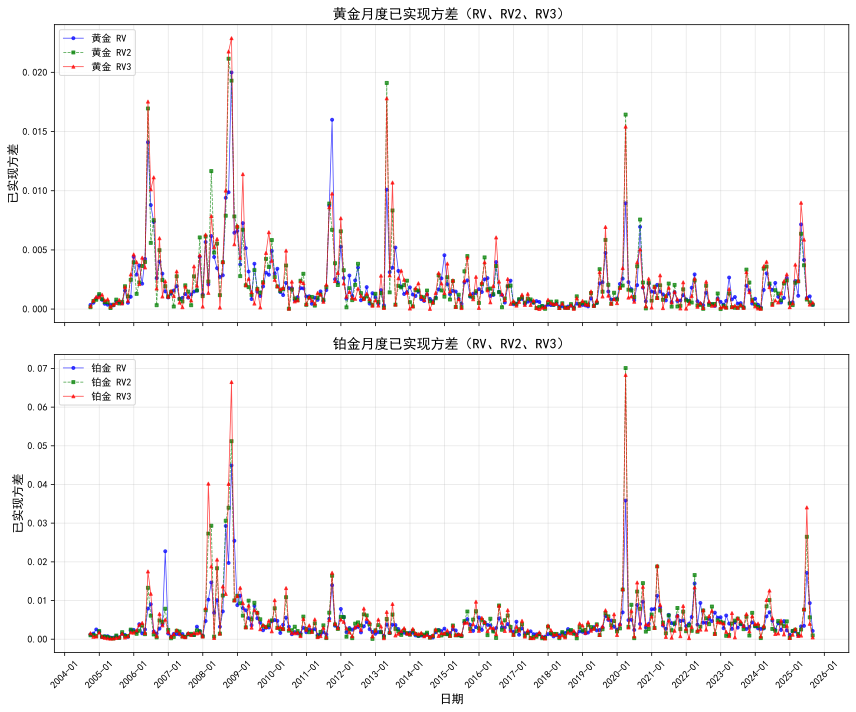

In [245]:
# 可视化：黄金和铂金的 RV3 对比
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号问题

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 第一个子图：黄金的 RV、RV2、RV3
ax1.plot(variance_data['gold_RV'], color='blue', marker='o', linewidth=0.8,
         markersize=3, linestyle='-', label='黄金 RV', alpha=0.7)
ax1.plot(variance_data['gold_RV2'], color='green', marker='s', linewidth=0.8,
         markersize=3, linestyle='--', label='黄金 RV2', alpha=0.7)
ax1.plot(variance_data['gold_RV3'], color='red', marker='^', linewidth=0.8,
         markersize=3, linestyle='-', label='黄金 RV3', alpha=0.7)
ax1.set_ylabel('已实现方差', color='black', fontsize=12)
ax1.set_title('黄金月度已实现方差（RV、RV2、RV3）', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 第二个子图：铂金的 RV、RV2、RV3
ax2.plot(variance_data['platinum_RV'], color='blue', marker='o', linewidth=0.8,
         markersize=3, linestyle='-', label='铂金 RV', alpha=0.7)
ax2.plot(variance_data['platinum_RV2'], color='green', marker='s', linewidth=0.8,
         markersize=3, linestyle='--', label='铂金 RV2', alpha=0.7)
ax2.plot(variance_data['platinum_RV3'], color='red', marker='^', linewidth=0.8,
         markersize=3, linestyle='-', label='铂金 RV3', alpha=0.7)
ax2.set_ylabel('已实现方差', color='black', fontsize=12)
ax2.set_xlabel('日期', fontsize=12)
ax2.set_title('铂金月度已实现方差（RV、RV2、RV3）', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
fig.savefig('图/goldptrv.jpg',dpi = 1000,bbox_inches='tight')
# 设置x轴的日期显示格式
date_format = mdates.DateFormatter('%Y-%m')
ax2.xaxis.set_major_formatter(date_format)
ax2.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [246]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对月对数收益率数据进行ADF检验，输入数据平稳，可进行未来预测
adf_result = ADF(variance_data['gold_RV'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')  #这里空格把输出的%往后空

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -6.6911
p-value: 0.0000
Critical Values:
   1%: -3.4568
   5%: -2.8732
   10%: -2.5730
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


In [247]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对月对数收益率数据进行ADF检验，输入数据平稳，可进行未来预测
adf_result = ADF(platinum_variance['platinum_RV3'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')  #这里空格把输出的%往后空

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -11.4468
p-value: 0.0000
Critical Values:
   1%: -3.4567
   5%: -2.8731
   10%: -2.5729
结论: p-value小于0.05，拒绝原假设，序列是平稳的。
